In [1]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

# Implementing a Generative Language Model with PyTorch

Paper on neural language model: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

Video on language model implementations in PyTorch: https://youtube.com/playlist?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ

## Goal: Can we generate convincing titles of mathematics papers?

### Mathematical Formulation:

* $V$ - vocabulary set

* $w \in V$ - token (character)

* $w_i^j = (w_i, w_{i+1} , \dots, w_{j-1}, w_j)$ - sequence of tokens (characters)

We wish to learn a conditional probability distribution $P(w_t | w_{1}^{t-1})$ on $V$ for the outcome of a new token $w_t$ given a previous sequence of tokens (context) is $w_1^{t-1}$.

Our $P$ will be the distribution of a dataset consiting of titles of research papers about machine learning taken from arXiv.

### Strategy

* Approximating $P(\cdot | w_{1}^{t-1})$ can be cost-prohibitive, so we will instead approximate
$$
    P(\cdot | w_{t-(n-1)}^{t-1})
$$
which only uses the previous $n-1$ tokens. We call this an $n$-gram model since we use the last $n-1$ characters to predict the $n$-th character.


* Approximate $P(\cdot| w_{t-(n-1)}^{t-1})$ with a feedforward neural network $f_{\theta}: V^{n-1} \to \mathcal{P}(V) \subset \mathbb{R}^{|V|}$ whose inputs are only the previous $n-1$ characters:
$$
    f_\theta (w_{t-(n-1)}, \dots, w_{t-1})(\cdot) \approx P(\cdot | w_{t-(n-1)}^{t-1})
$$

* Embed our vocabulary into a lower dimensional space with dimension $m < |V|$ via an embedding function $C: V \to \mathbb{R}^m$ and feed this embedding to our NN.

* In our case this embedding map $C$ wil be represented as multiplication by a $|V| \times m$ matrix with tweakable entries.

* To train our NN $f_\theta$, we will use stochastic gradient descent to maximize the log probability that $w_t$ (sampled from the trainng data) is sampled from $f_\theta$
$$
    L(\theta) = - \log f_\theta (w_{t-(n-1)}, \dots, w_{t-1})(w_t)
$$
This is known as the *cross-entropy loss* or *negative log likelihood loss*.

### Read in titles from csv file and inspect data

In [2]:
df = pd.read_csv('arxiv-papers.csv')
title_list = df['title'].tolist()
title_list = [title + '\n' for title in title_list]
title_list[:3]

['A determinant of Stirling cycle numbers counts unlabeled acyclic single-source automata\n',
 'Partial cubes: structures, characterizations, and constructions\n',
 'Distribution of integral Fourier Coefficients of a Modular Form of Half Integral Weight Modulo Primes\n']

### Build vocabulary for the model

In [3]:
char_list = [char for title in title_list for char in title]
vocabulary = sorted(list(set(char_list)))
vocab_size = len(vocabulary)

print(''.join(vocabulary))
print(vocab_size)
print(len(char_list))


 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~¦â
100
7527365


### Encode vocabulary into integers

In [4]:
stoi = {ch:i for i, ch in enumerate(vocabulary)}
itos = {i:ch for i, ch in enumerate(vocabulary)}

### Process data into inputs and targets

Try testing out different block sizes for the context:

In [5]:
block_size = 20

X, Y = [], []
for title in title_list:
    context = [0] * block_size
    for ch in title:
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)

### Simple function to generate mini-batches of data

In [6]:
def generate_batch(batch_size):
    ix = torch.randint(0, X.shape[0], (batch_size, ))
    return X[ix], Y[ix]

### Implement neural network architecture for our model

In [7]:
class NGramModel(nn.Module):
    
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embedding_size = embedding_size
        self.embedding_layer = nn.Embedding(vocab_size, embedding_size)
        self.linear_layer1 = nn.Linear(self.embedding_size * block_size, 128)
        self.linear_layer2 = nn.Linear(128, vocab_size)
        
    def forward(self, x):
        x = self.embedding_layer(x)
        x = self.linear_layer1( x.view(-1, self.embedding_size * block_size) )
        x = torch.tanh(x)
        x = self.linear_layer2(x)
        return x
    
    @torch.no_grad()
    def generate(self, n_titles, temp=1):
        """
        Generates `n_titles` number of titles separated by newline characters.
        The `temp` parameter adjusts how diffuse or deterministic the distribution
        of the next character is.
        """
        out = []
        for _ in range(n_titles):
            context = [0] * block_size
            while True:
                logits = self(torch.tensor(context)) * temp
                probs = torch.softmax(logits, dim=-1)
                ix = torch.multinomial(probs, num_samples=1).item()
                out.append(itos[ix])
                context = context[1:] + [ix]
                if ix == 0:
                    break
        print(''.join(out))

Try testing out different embedding sizes:

In [8]:
model = NGramModel(vocab_size, 64)
model.generate(1)

jfQ$N zK gav!T;}M9T;]]"R+dq7WoMW^lAY9zi6YD~0 <U1¦0a&?u_xA=9('y']s:>IEI9zSIBj%.SBOnB}/e<5/6B\7<5!T%]D"<sâY#W~Gy@*D!+XOgszomz~-.zN|Rptr2pq$gZBvb$6?HuGpECt^\.OdYxR'x~~#9lâU-(3&kl^r-Ta}rZ/(3U*1*Lg1a)["v[[*Ne(¦zrqk94\v\@FmYbHvXhSjI



### Train the model using Negative Log Likelihood Loss

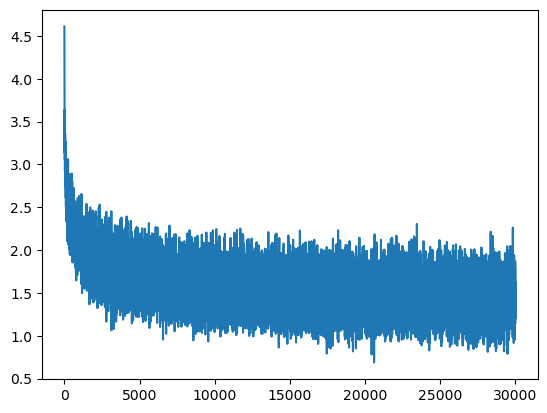

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = []

for _ in range(30_000):
    X_batch, Y_batch = generate_batch(64)
    logits = model(X_batch)
    probs = torch.softmax(logits, dim=-1)
    log_probs = torch.log(probs)
    loss = nn.functional.nll_loss(log_probs, Y_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
plt.plot(losses)

### Generate some titles with the trained model

In [14]:
model.generate(4, 2)

Compressive Autometric Network for Model for Sense conal stative Semantic Face Sy the Convolutional Neural Networks
A News Domain Adaptation
The Reconstruction Network for Deep Neural Networks for Setective Analysis of Adversarial Network for Networks with Application to Statistication of Visual Sameration Problem
A Novel Learning to Proformance Sequences



### Visualize the probabilities

Input a string of characters into `context_str` to see the probablity distribution of the next character. You can play wth the `temp` parameter to make the distribution more or less diffuse:

/opt/homebrew/Caskroom/miniforge/base/envs/nlp_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/envs/nlp_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128 (\x80) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


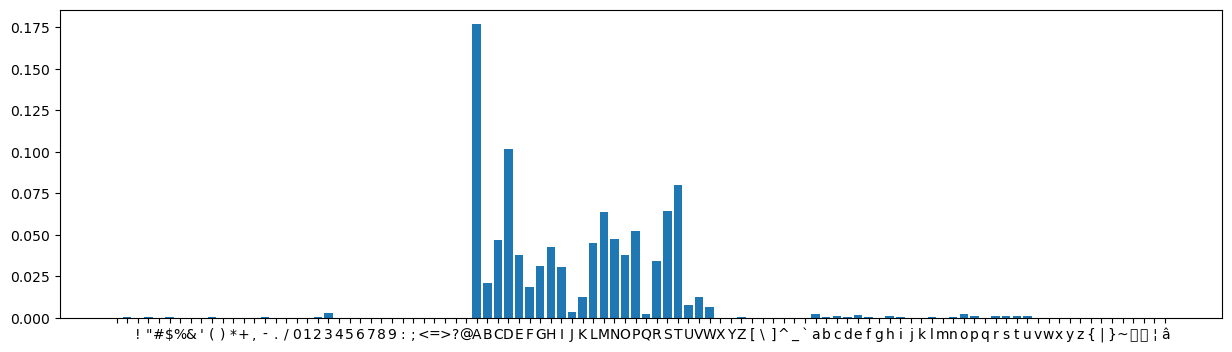

In [15]:
# Make sure the length of `context_str` is no more than `block_size`
context_str = ''
temp = 1

context = [0] * (block_size - len(context_str))
context += [stoi[ch] for ch in context_str]
with torch.no_grad():
    logits = model(torch.tensor(context)) * temp
    probs = torch.softmax(logits, dim=-1)
probs = probs.numpy().squeeze()

fig, ax = plt.subplots(figsize=(15,4))
ax.bar(range(len(probs)), probs)
ax.set_xticks(range(len(probs)))
ax.set_xticklabels(vocabulary)
plt.show()